<a href="https://colab.research.google.com/github/RaphaelUCL/all/blob/main/Intro_to_market_making.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Market Making: Mathematical Foundations and Python Implementation

## 1. Introduction to Market Making

Market makers are financial intermediaries who provide liquidity to markets by continuously quoting both buy (bid) and sell (ask) prices. They earn profit primarily through the bid-ask spread while managing inventory risk.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tqdm.notebook import tqdm

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


## 2. Mathematical Foundations of Market Making

### 2.1 Basic Terminology

Understanding the terminology of market making is essential before diving into mathematical models. Below are key concepts used throughout this project:

- **Bid Price**: The maximum price a market maker is willing to pay to buy a unit of an asset. It reflects demand in the market.

- **Ask Price**: The minimum price a market maker is willing to accept to sell a unit of an asset. It reflects supply in the market.

- **Mid Price**: The average of the bid and ask prices. It serves as an estimate of the asset's fair value in the absence of market frictions.

   $$
  \text{Mid Price} = \frac{\text{Bid Price} + \text{Ask Price}}{2}
  $$

- **Spread**: The difference between the ask and the bid price. It represents the market maker's compensation for providing liquidity and taking on risk.

    $$
  \text{Spread} = \text{Ask Price} - \text{Bid Price}
  $$

- **Inventory**: The net position held by the market maker, i.e., the quantity of the asset currently owned (positive) or owed (negative). Managing inventory is crucial to limit exposure to price risk.

- **Order Book**: A record of all outstanding buy and sell orders in the market, typically organized by price level. It provides insight into market depth and liquidity.

- **Liquidity**: A measure of how easily an asset can be bought or sold without significantly affecting its price. Market makers enhance liquidity by continuously quoting bid and ask prices.

- **Market Making Strategy**: A set of rules or an algorithm that determines how a market maker quotes prices and sizes, based on market conditions, inventory, and risk preferences.




In [18]:
def calculate_spread(bid, ask):
    return ask - bid

def calculate_mid_price(bid, ask):
    return (bid + ask) / 2

# Example values
bid_price = 97.75
ask_price = 98.25

# Function calls
spread = calculate_spread(bid_price, ask_price)
mid_price = calculate_mid_price(bid_price, ask_price)

# Display results
print(f"Bid Price: {bid_price}")
print(f"Ask Price: {ask_price}")
print(f"Spread: {spread}")
print(f"Mid Price: {mid_price}")



Bid Price: 97.75
Ask Price: 98.25
Spread: 0.5
Mid Price: 98.0


### 2.2 The Avellaneda-Stoikov Model

The Avellaneda-Stoikov model is a foundational framework in algorithmic market making.  
It helps market makers determine optimal bid and ask quotes while balancing profit and inventory risk.

#### Objective:
Maximize expected utility of terminal wealth over a short time horizon, taking into account:
- **Market volatility**
- **Inventory risk**
- **Time to maturity**

####  Key Assumptions:
- The reference price follows a Brownian motion.
- The arrival of buy/sell orders is modeled by a **Poisson process**, with intensity depending on the distance from the mid price.
- The market maker uses **exponential utility** to account for risk aversion.

#### Core Idea:
The further your quotes are from the mid price, the less likely they are to be executed —  
but placing them too close increases inventory risk.

#### Optimal Quotes (foundation):

Let:
$$
\begin{aligned}
\gamma &:\ \text{risk aversion coefficient} \\
\sigma &:\ \text{volatility} \\
T - t &:\ \text{time remaining} \\
q &:\ \text{current inventory} \\
S_t &:\ \text{mid price}
\end{aligned}
$$


Then the optimal bid and ask prices are:

$$
\begin{aligned}
p_{\text{bid}} &= S_t - q \cdot \gamma \cdot \sigma^2 (T - t) \\
p_{\text{ask}} &= S_t + q \cdot \gamma \cdot \sigma^2 (T - t)
\end{aligned}
$$


These formulas shift the quotes based on inventory:  
- If inventory \( q > 0 \): you lower the bid and raise the ask to reduce position.  
- If \( q < 0 \): you raise the bid and lower the ask to accumulate.



In [17]:
def avellaneda_stoikov_quotes(s, q, gamma, sigma, T, t, k):
    tau = T - t
    r = s + gamma * sigma**2 * q * tau
    delta = (1/gamma) * np.log(1 + (gamma/k))
    bid_price = r - delta
    ask_price = r + delta
    return bid_price, ask_price

# Example parameters
s = 100        # mid price
q = 2          # inventory
gamma = 0.1    # risk aversion
sigma = 0.2    # volatility
T = 1.0        # time horizon
t = 0.0        # current time
k = 1.5        # market depth parameter

bid, ask = avellaneda_stoikov_quotes(s, q, gamma, sigma, T, t, k)

print(f"Optimal Bid Price: {bid:.2f}")
print(f"Optimal Ask Price: {ask:.2f}")



Optimal Bid Price: 99.36
Optimal Ask Price: 100.65


## 3. Simulating a Simple Market Making Strategy

In this section, we simulate a basic market making strategy using the Avellaneda-Stoikov model.

We'll follow these steps:
- **3.1** Simulate a price path for an asset using Geometric Brownian Motion (GBM).
- **3.2** Implement a basic market making algorithm that quotes bid and ask prices dynamically.
- **3.3** Visualize the results to analyze the market maker's inventory and profit-and-loss (PnL) over time.


### 3.1 Simulating Asset Price

We model the asset price as a **Geometric Brownian Motion**, which is a standard model in quantitative finance.

This model assumes continuous returns are normally distributed and allows us to simulate realistic price movements.


In [19]:

def simulate_price_path(S0, mu, sigma, T, dt):
    """
    Simulates an asset price path using Geometric Brownian Motion.

    Parameters:
        S0 (float): Initial price
        mu (float): Drift (expected return)
        sigma (float): Volatility
        T (float): Time horizon
        dt (float): Time step size

    Returns:
        np.array: Simulated price path
    """
    n_steps = int(T / dt)
    prices = np.zeros(n_steps + 1)
    prices[0] = S0
    for i in range(1, n_steps + 1):
        dW = np.random.normal(0, np.sqrt(dt))
        prices[i] = prices[i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW)
    return prices



### 3.2 Market Making Simulation

We simulate a market maker who uses the **Avellaneda-Stoikov model** to quote optimal bid and ask prices  
based on their current inventory and risk aversion.

At each step:
- The market maker updates their quotes.
- Random orders may arrive (simulated using a Poisson process).
- Inventory and cash are updated accordingly.


In [20]:
# Avellaneda-Stoikov quoting function
def avellaneda_stoikov_quotes(s, q, gamma, sigma, T, t, k):
    tau = T - t
    r = s + gamma * sigma**2 * q * tau
    delta = (1 / gamma) * np.log(1 + (gamma / k))
    return r - delta, r + delta  # bid, ask

# Market making simulation
def run_market_making_simulation(S0=100, mu=0, sigma=0.2, T=1.0, dt=0.001, gamma=0.1, k=1.5, lambda_rate=50):
    n_steps = int(T / dt)
    times = np.linspace(0, T, n_steps + 1)
    prices = simulate_price_path(S0, mu, sigma, T, dt)

    results = {
        'time': times,
        'mid_price': prices,
        'bid_price': np.zeros_like(prices),
        'ask_price': np.zeros_like(prices),
        'inventory': np.zeros_like(prices),
        'cash': np.zeros_like(prices),
        'pnl': np.zeros_like(prices)
    }

    inventory = 0
    cash = 0

    for i in range(n_steps + 1):
        t = times[i]
        s = prices[i]
        bid, ask = avellaneda_stoikov_quotes(s, inventory, gamma, sigma, T, t, k)

        results['bid_price'][i] = bid
        results['ask_price'][i] = ask
        results['inventory'][i] = inventory
        results['cash'][i] = cash
        results['pnl'][i] = cash + inventory * s

        # Simulate order arrival
        if i < n_steps:
            order_arrival = np.random.binomial(1, lambda_rate * dt)
            if order_arrival:
                is_buy = np.random.binomial(1, 0.5)
                if is_buy and bid > 0:
                    inventory += 1
                    cash -= bid
                elif not is_buy:
                    inventory -= 1
                    cash += ask

    return pd.DataFrame(results)


### 3.3 Visualizing the Results

We now plot the evolution of:
- Mid price, bid, and ask quotes
- Inventory over time
- Profit and Loss (PnL) generated by the strategy


In [21]:
def plot_simulation_results(results):
    fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

    axes[0].plot(results['time'], results['mid_price'], label='Mid Price', color='black')
    axes[0].plot(results['time'], results['bid_price'], label='Bid Price', color='red', alpha=0.7)
    axes[0].plot(results['time'], results['ask_price'], label='Ask Price', color='green', alpha=0.7)
    axes[0].set_ylabel("Price")
    axes[0].legend()
    axes[0].set_title("Mid, Bid, and Ask Prices")

    axes[1].plot(results['time'], results['inventory'], color='blue')
    axes[1].set_ylabel("Inventory")
    axes[1].set_title("Inventory Over Time")

    axes[2].plot(results['time'], results['pnl'], color='purple')
    axes[2].set_ylabel("PnL")
    axes[2].set_xlabel("Time")
    axes[2].set_title("Profit and Loss (PnL) Over Time")

    plt.tight_layout()
    plt.show()


## 4. Running the Simulation

This line executes the market-making simulation with the specified parameters:
- **`S0=100`**: Initial asset price
- **`mu=0.05`**: Expected return (drift)  
- **`sigma=0.2`**: Volatility
- **`T=1.0`**: Total simulation time  
- **`dt=0.001`**: Time step
- **`gamma=0.1`**: Risk aversion
- **`k=1.5`**: Market depth parameter
- **`lambda_rate=50`**: Order arrival intensity

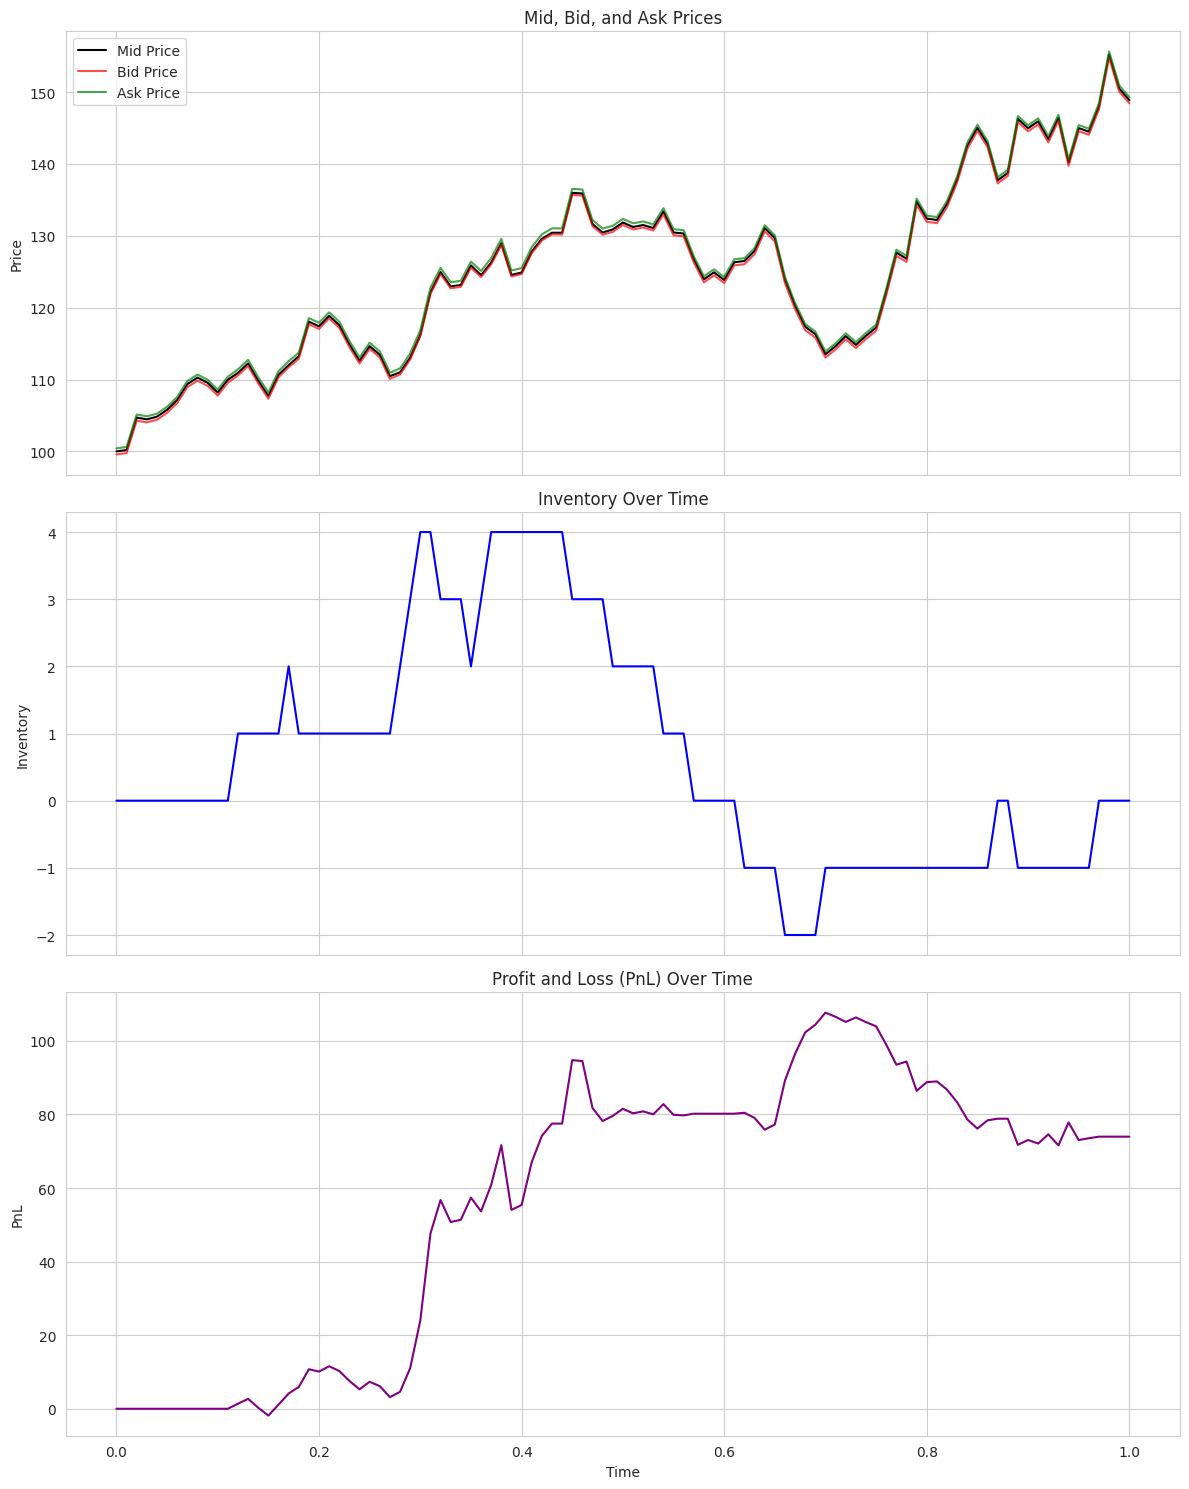

In [54]:
np.random.seed(18)

simulation_results = run_market_making_simulation(
    S0=100,
    mu=0.05,
    sigma=0.2,
    T=1.0,
    dt=0.01,
    gamma=2,
    k=1.5,
    lambda_rate=15
)

plot_simulation_results(simulation_results)



## 5. Conclusion

By experimenting with different parameters, we clearly observe how the behavior and performance of the market making strategy change drastically.

Key insights:
- The risk aversion parameter (`gamma`) strongly influences how aggressively the market maker quotes. Higher `gamma` leads to safer but less frequent trades.
- The time step (`dt`) affects both the frequency of price updates and the probability of order arrivals, indirectly impacting inventory risk and profitability.
- The order arrival rate (`lambda_rate`) determines how often the market maker interacts with the market. A higher `lambda_rate` increases trading activity but also raises the risk of accumulating excessive inventory.
- Even small changes in the market environment (like volatility or order arrival rate) can flip a strategy from profitable to losing.

This highlights the importance of **careful calibration**, **inventory control**, and **sensitivity analysis** when designing algorithmic market making strategies.
